#### Writing an article using LLM on some topic, revising it and editing it.

The key here is that the steps are known. There is one time revision here. There is no iterative loop here.
1. write the article
2. generate TOC
3. revise article, if needed
4. done

In [1]:
import os
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool

import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field


In [2]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [3]:

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

#### Describe the State(s)

Here all states are encapsulated in one dictionary

In [4]:
class State(TypedDict):
    topic: str
    table_of_contents: str
    content: str
    revised_content: str

In [6]:
def generate_table_of_contents(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state['topic']}"
        ),
    ]
    return {"table_of_contents": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['topic']} with the following table of contents: {state['table_of_contents']}"
        ),
    ]
    return {"content": model.invoke(messages).content}


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of an article about {state['topic']} with the following table of contents: {state['table_of_contents']} and the following content:\n\n{state['content']}"
        ),
    ]
    return {"revised_content": model.invoke(messages).content}


def check_article_content(state: State) -> str:
    if len(state["content"]) > 1000:
        return "Fail"
    return "Pass"

In [10]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)

workflow_builder.add_edge(START, "generate_table_of_contents")
workflow_builder.add_edge("generate_table_of_contents", "generate_article_content")
workflow_builder.add_conditional_edges(
    source = "generate_article_content",
    path =check_article_content,
    path_map = {
        "Pass": END,
        "Fail": "revise_article_content",
    },
)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()


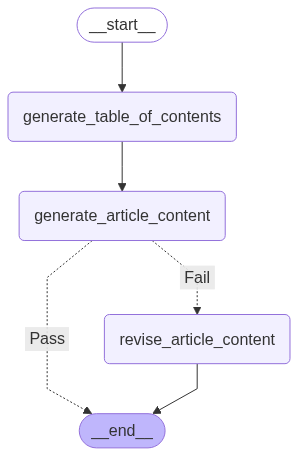

In [11]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [12]:
article = workflow.invoke({"topic": "Artificial Intelligence"})

In [15]:
article

{'topic': 'Artificial Intelligence',
 'table_of_contents': 'Table of Contents\n\n1. Introduction to Artificial Intelligence  \n2. History and Evolution of AI  \n3. Types of Artificial Intelligence  \n4. Key Technologies Behind AI  \n5. Applications of Artificial Intelligence  \n6. Benefits and Challenges of AI  \n7. The Future of Artificial Intelligence  \n8. Ethical Considerations in AI  \n9. Conclusion',
 'content': '# Artificial Intelligence: Transforming the Future of Technology\n\n## 1. Introduction to Artificial Intelligence\n\nArtificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think, learn, and make decisions. These intelligent systems can perform tasks that typically require human cognition, such as understanding natural language, recognizing patterns, solving problems, and adapting to new information. AI is revolutionizing various industries by enhancing efficiency, accuracy, and innovation.\n\n## 2. History and Evolu